# Maps

In [122]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from PIL import Image, ImageDraw
import joblib
from shapely.geometry import Point, LineString, Polygon
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

In [ ]:
# Configuration parameters
NUM_CLUSTERS = 4  # Number of clusters for K-means
OUTPUT_SIZE = (800, 800)  # Size of output images
ZOOM_LEVEL = 17  # Zoom level for HERE Maps API
API_KEY = "API-HERE"

def latlon_to_tile(lat, lon, zoom):
    """Convert latitude/longitude to tile coordinates"""
    lat_rad = np.radians(lat)
    n = 2.0 ** zoom
    x = int((lon + 180.0) / 360.0 * n)
    y = int((1.0 - np.log(np.tan(lat_rad) + (1 / np.cos(lat_rad))) / np.pi) / 2.0 * n)
    return x, y

def download_tile_image(lon, lat):
    """Download satellite imagery from HERE Maps API"""
    try:
        x, y = latlon_to_tile(lat, lon, ZOOM_LEVEL)
        url = f"https://maps.hereapi.com/v3/base/mc/{ZOOM_LEVEL}/{x}/{y}/png?apiKey={API_KEY}&style=satellite.day&size=512"
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert('RGB')
    except Exception as e:
        print(f"Failed to download image for ({lon:.4f}, {lat:.4f}): {str(e)}")
        return None

def load_geospatial_data(poi_path, street_path, voronoi_path):
    """
    Load the three GeoJSON layers with appropriate error handling
    """
    print("Loading GeoJSON data files...")

    try:
        # Load only 2000 random POIs
        pois = gpd.read_file(poi_path, low_memory=False)
        pois = pois.sample(n=3000, random_state=42)
        print(f"Loaded POIs: {len(pois)} records")
        
        # Check if we need to convert POIs from LineString to Point
        if 'LineString' in str(pois.geometry.iloc[0]):
            print("Converting POI LineStrings to Points (using first point of each line)...")
            pois['orig_geometry'] = pois.geometry  # Keep original geometry
            # Extract the first point from each LineString
            pois['geometry'] = pois.geometry.apply(lambda line: Point(line.coords[0]))
    
        # Load street Voronoi polygons
        streets = gpd.read_file(street_path, low_memory=False)
        print(f"Loaded streets: {len(streets)} records")
        
        # Load building polygons - use a separate file if available
        voronoi = gpd.read_file(voronoi_path, low_memory=False)
        print(f"Loaded Voronoi polygons: {len(voronoi)} records")
        
        # Ensure all are in the same coordinate system
        if pois.crs != streets.crs:
            print("Converting street data to match POI CRS...")
            streets = streets.to_crs(pois.crs)
        
        if pois.crs != voronoi.crs:
            print("Converting Voronoi data to match POI CRS...")
            voronoi = voronoi.to_crs(pois.crs)
            
        # Assign common CRS if any is missing
        if pois.crs is None:
            print("Setting CRS for POIs to EPSG:4326")
            pois.set_crs(epsg=4326, inplace=True)
            
        if streets.crs is None:
            print("Setting CRS for streets to EPSG:4326")
            streets.set_crs(epsg=4326, inplace=True)
            
        if voronoi.crs is None:
            print("Setting CRS for Voronoi to EPSG:4326")
            voronoi.set_crs(epsg=4326, inplace=True)
            
        return pois, streets, voronoi
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def extract_poi_features(pois, buildings, streets):
    """
    Extract spatial features from POIs based on their relationship with buildings and streets
    """
    print("Extracting features from POIs...")
    
    features_list = []
    
    # Process each POI
    for idx, poi in pois.iterrows():
        try:
            # Initialize features dictionary
            features = {'poi_id': idx}
            
            # Get POI coordinates
            poi_point = poi.geometry
            lon = poi_point.x
            lat = poi_point.y
            features['lon'] = lon
            features['lat'] = lat
            
            # Feature: Is there a building underneath?
            buildings_under = buildings[buildings.intersects(poi_point)]
            features['has_building'] = not buildings_under.empty
            
            # Feature: Building area underneath (if exists)
            if features['has_building']:
                features['building_area'] = buildings_under.area.sum()
            else:
                features['building_area'] = 0.0
            
            # Feature: Distance to nearest street
            if not streets.empty:
                features['dist_nearest_road'] = streets.distance(poi_point).min()
            else:
                features['dist_nearest_road'] = -1.0
            
            # Feature: Building density in radius
            buffer = poi_point.buffer(0.001)  # ~100m in degrees
            buildings_nearby = buildings[buildings.intersects(buffer)]
            features['building_density'] = len(buildings_nearby)
            
            # Feature: Street density in radius
            streets_nearby = streets[streets.intersects(buffer)]
            features['road_density'] = len(streets_nearby)
            
            # Feature: Nearby POIs (potential duplicates)
            buffer_small = poi_point.buffer(0.0002)  # ~20m in degrees
            nearby_pois = pois[pois.geometry.intersects(buffer_small)]
            features['nearby_poi_count'] = len(nearby_pois) - 1  # Subtract the current POI
            
            # Add any POI-specific attributes that might be useful
            if 'POI_NAME' in poi:
                features['poi_name'] = poi['POI_NAME']
            
            if 'FAC_TYPE' in poi:
                features['facility_type'] = poi['FAC_TYPE']
                
            features_list.append(features)
            
            if idx % 100 == 0 and idx > 0:
                print(f"Processed {idx} POIs...")
                
        except Exception as e:
            print(f"Error processing POI {idx}: {str(e)}")
    
    # Create DataFrame with all features
    feature_df = pd.DataFrame(features_list)
    
    return feature_df

def create_map_visualization_with_satellite(poi, buildings, streets, voronoi, output_path, radius=0.002):
    """
    Create a visualization map for a POI showing buildings, streets and satellite imagery
    with all three GeoJSON layers
    """
    # Verifica que el radio sea un valor válido
    if not (radius > 0 and np.isfinite(radius)):
        print(f"Radio inválido: {radius}, usando valor predeterminado")
        radius = 0.002
    
    # Extract POI location
    poi_point = poi.geometry
    center_x = poi_point.x
    center_y = poi_point.y
    
    # Create bounding box around POI
    minx = center_x - radius
    miny = center_y - radius
    maxx = center_x + radius
    maxy = center_y + radius
    
    # Verify that the dimensions are valid before creating the figure
    if maxx <= minx or maxy <= miny:
        print(f"Invalid dimensions for POI {poi.name}: minx={minx}, maxx={maxx}, miny={miny}, maxy={maxy}")
        # Adjusts dimensions to ensure a positive aspect ratio
        if maxx <= minx:
            maxx = minx + 0.001
        if maxy <= miny:
            maxy = miny + 0.001
    
    # Filter data to bounding box
    bbox_buildings = buildings.cx[minx:maxx, miny:maxy]
    bbox_streets = streets.cx[minx:maxx, miny:maxy]
    bbox_voronoi = voronoi.cx[minx:maxx, miny:maxy]
    
    # Download satellite imagery if API_KEY is provided
    satellite_img = None
    if API_KEY != "YOUR_HERE_API_KEY":
        satellite_img = download_tile_image(center_x, center_y)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Add satellite imagery if available
    if satellite_img:
        img_extent = (minx, maxx, miny, maxy)
        ax.imshow(satellite_img, extent=img_extent, alpha=0.5, zorder=0)
    
    # Plot all three layers with different styles
    bbox_voronoi.plot(ax=ax, color='none', edgecolor='yellow', alpha=0.7, linewidth=1, zorder=1, 
                     label='Voronoi Polygons')
    bbox_buildings.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.5, zorder=2, 
                       label='Buildings')
    bbox_streets.plot(ax=ax, color='skyblue', linewidth=1.5, zorder=3, 
                     label='Streets')
    
    # Plot POI
    ax.scatter(center_x, center_y, c='red', s=90, marker='*', edgecolor='black', zorder=4, 
              label='POI')
    
    # Draw a small buffer around POI to check intersections
    buffer = poi_point.buffer(0.0001)  # ~10m buffer
    x, y = buffer.exterior.xy
    ax.plot(x, y, color='red', linestyle='--', linewidth=1, zorder=4)
    
    # Set plot bounds
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    
    # Add title and legend
    if 'POI_NAME' in poi and not pd.isna(poi['POI_NAME']):
        title = f"POI: {poi['POI_NAME']} (ID: {poi.name})"
    else:
        title = f"POI ID: {poi.name}"
    ax.set_title(title, fontsize=14)
    
    # Add a compact legend
    ax.legend(loc='upper right', fontsize='small')
    
    # Add info about building intersection
    is_on_building = bbox_buildings.intersects(poi_point).any()
    info_text = f"On building: {'Yes' if is_on_building else 'No'}"
    ax.text(minx + 0.0001, miny + 0.0001, info_text, 
            bbox=dict(facecolor='white', alpha=0.7), fontsize=10)
    
    # Save figure
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    return output_path, is_on_building

def generate_validation_maps(pois, buildings, streets, voronoi, output_dir, sample_size=20):
    """
    Generate map visualizations for a sample of POIs with satellite imagery
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Sample POIs (or use all if fewer than sample_size)
    if len(pois) > sample_size:
        sampled_pois = pois.sample(sample_size, random_state=42)
    else:
        sampled_pois = pois
    
    # Generate maps
    map_paths = []
    building_status = []
    
    for idx, poi in sampled_pois.iterrows():
        output_path = os.path.join(output_dir, f"poi_{idx}_map.png")
        try:
            path, on_building = create_map_visualization_with_satellite(
                poi, buildings, streets, voronoi, output_path)
            map_paths.append(path)
            building_status.append(on_building)
            
            if len(map_paths) % 5 == 0:
                print(f"Generated {len(map_paths)} maps...")
                
        except Exception as e:
            print(f"Error generating map for POI {idx}: {str(e)}")
    
    print(f"Generated {len(map_paths)} POI validation maps")
    return map_paths, building_status

def cluster_pois(feature_df, num_clusters=NUM_CLUSTERS):
    """
    Cluster POIs using K-means on scaled features
    """
    print("Clustering POIs...")
    
    # Features to use for clustering - expanded set
    cluster_columns = [
        'has_building', 
        'building_area', 
        'dist_nearest_road', 
        'building_density', 
        'road_density', 
        'nearby_poi_count'
    ]
    
    # Prepare features
    features = feature_df[cluster_columns].fillna(0).values
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(features_scaled.shape[1], 5))
    features_pca = pca.fit_transform(features_scaled)
    
    # Print explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA explained variance: {explained_variance}")
    print(f"Total variance explained: {sum(explained_variance)*100:.2f}%")
    
    # Apply K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features_pca)
    
    # Add cluster to DataFrame
    feature_df['cluster'] = clusters
    
    # Apply DBSCAN for anomaly detection
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_clusters = dbscan.fit_predict(features_pca)
    
    # Mark anomalies (-1 in DBSCAN are outliers)
    feature_df['is_anomaly'] = (dbscan_clusters == -1)
    print(f"Detected {feature_df['is_anomaly'].sum()} anomalies using DBSCAN")
    
    # Save models
    os.makedirs('models', exist_ok=True)
    joblib.dump(scaler, 'models/poi_scaler.pkl')
    joblib.dump(pca, 'models/poi_pca.pkl')
    joblib.dump(kmeans, 'models/poi_kmeans.pkl')
    
    # Create t-SNE visualization with more detail
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features_pca)
    
    # Create a more informative cluster visualization
    plt.figure(figsize=(14, 12))
    
    # Plot points colored by cluster
    scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                         c=clusters, cmap='viridis', alpha=0.7, s=30)
    
    # Mark anomalies
    anomalies = feature_df['is_anomaly']
    if anomalies.sum() > 0:
        plt.scatter(tsne_features[anomalies, 0], tsne_features[anomalies, 1], 
                   marker='x', color='red', s=30, label='Anomalies')
    
    # Add cluster centers
    centers_pca = kmeans.cluster_centers_
    if centers_pca.shape[1] >= 2:
        # If we have 2D PCA space, use it directly
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                   marker='o', color='red', s=30, alpha=0.5, 
                   edgecolor='black', label='Cluster Centers')
    
    # Improve legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    if anomalies.sum() > 0:
        plt.legend(["Anomalies"], loc="upper right")
    
    plt.title("POI Clustering (t-SNE)", fontsize=16)
    plt.tight_layout()
    
    # Save visualization
    os.makedirs('output', exist_ok=True)
    plt.savefig('output/poi_clusters_tsne.png', dpi=150)
    plt.close()
    
    # Create feature importance visualization
    cluster_means = []
    
    # Calculate mean values for each cluster
    for cluster_id in range(num_clusters):
        cluster_data = feature_df[feature_df['cluster'] == cluster_id][cluster_columns]
        cluster_means.append(cluster_data.mean())
    
    # Create a DataFrame for visualization
    cluster_profiles = pd.DataFrame(cluster_means, index=[f"Cluster {i}" for i in range(num_clusters)])
    
    # Plot the profile heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_profiles, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title("Cluster Feature Profiles", fontsize=16)
    plt.tight_layout()
    plt.savefig('output/cluster_profiles.png', dpi=150)
    plt.close()
    
    return feature_df

def evaluate_clustering(feature_df, output_dir):
    """
    Evaluates clustering quality and generates visualizations
    Returns metrics and image paths
    """
    # Make sure that the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Select characteristics used for clustering
    features = feature_df[['nearby_poi_count', 'building_density', 'road_density', 'has_building']]
    
    # Convert Boolean column to numeric if needed
    if features['has_building'].dtype == bool:
        features['has_building'] = features['has_building'].astype(int)
    
    # Handle NaN values if any
    features = features.fillna(0)
    
    # Calculate metrics
    try:
        metrics = {
            'silhouette': silhouette_score(features, feature_df['cluster']),
            'davies_bouldin': davies_bouldin_score(features, feature_df['cluster']),
            'calinski_harabasz': calinski_harabasz_score(features, feature_df['cluster'])
        }
    except Exception as e:
        print(f"Error when calculating clustering metrics: {str(e)}")
        # Provide defaults if it fails
        metrics = {
            'silhouette': -1,
            'davies_bouldin': -1,
            'calinski_harabasz': -1
        }
    
    # Generate PCA display
    try:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(features)
        
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(pca_result[:,0], pca_result[:,1], c=feature_df['cluster'], cmap='tab10', alpha=0.6)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('Cluster Visualization (PCA)')
        plt.legend(*scatter.legend_elements(), title="Clusters")
        pca_path = os.path.join(output_dir, 'cluster_pca.png')
        plt.savefig(pca_path)
        plt.close()
    except Exception as e:
        print(f"Error generating PCA display: {str(e)}")
        pca_path = ""
    
    return metrics, pca_path

def classify_pois(feature_df):
    """
    Automatically classify POIs into validation categories:
    - No POI in reality
    - Incorrect POI location
    - Incorrect Multiply Digitized attribution
    - Legitimate Exception from the rule
    """
    print("Classifying POIs into validation categories...")
    
    # Initialize validation class column
    feature_df['validation_class'] = 'Legitimate Exception'  # Default
    
    # Rule 1: No POI in reality - anomalies or very low building/road density
    mask_no_poi = (
        feature_df['is_anomaly'] | 
        ((feature_df['building_density'] < 1) & 
         (feature_df['road_density'] < 1))
    )
    feature_df.loc[mask_no_poi, 'validation_class'] = 'No POI in reality'
    
    # Rule 2: Incorrect POI location - no building underneath in built-up area
    mask_incorrect_location = (
        (~feature_df['has_building']) & 
        (feature_df['building_density'] > 3) &
        (~mask_no_poi)
    )
    feature_df.loc[mask_incorrect_location, 'validation_class'] = 'Incorrect POI location'
    
    # Rule 3: Multiply Digitized - many nearby POIs
    mask_multiply_digitized = (
        (feature_df['nearby_poi_count'] > 1) &
        (~mask_no_poi) &
        (~mask_incorrect_location)
    )
    feature_df.loc[mask_multiply_digitized, 'validation_class'] = 'Incorrect Multiply Digitised'
    
    # Rule 4: Legitimate exceptions - those that don't match other rules
    # (Already set as default)
    
    # Count instances in each category
    class_counts = feature_df['validation_class'].value_counts()
    print("\nPOI Classification Results:")
    for category, count in class_counts.items():
        print(f"- {category}: {count} POIs ({count/len(feature_df)*100:.1f}%)")
    
    return feature_df

def generate_map_with_validation(pois, buildings, streets, voronoi, classifications, output_path):
    """
    Create a map visualization with POIs colored by validation class
    Uses all three GeoJSON layers
    """
    # Set up plot
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Force aspect ratio to be equal instead of calculating it
    ax.set_aspect('equal')
    
    # Plot all three layers
    voronoi.plot(ax=ax, color='none', edgecolor='magenta', alpha=0.4, linewidth=0.5, zorder=1, 
               label='Voronoi Polygons')
    buildings.plot(ax=ax, color='lightgray', alpha=0.3, zorder=2, label='Buildings')
    streets.plot(ax=ax, color='DodgerBlue', linewidth=0.5, zorder=3, label='Streets')
    
    # Define colors and labels for categories
    class_colors = {
        'No POI in reality': 'red',
        'Incorrect POI location': 'orange',
        'Incorrect Multiply Digitised': 'purple',
        'Legitimate Exception': 'green'
    }
    
    # Create a GeoDataFrame with POIs and their classifications
    gdf_with_class = pois.copy()
    
    # Join classifications to POIs
    class_dict = dict(zip(classifications['poi_id'], classifications['validation_class']))
    gdf_with_class['validation_class'] = gdf_with_class.index.map(lambda idx: class_dict.get(idx, 'Unknown'))
    
    # Plot each category separately for the legend
    for category, color in class_colors.items():
        subset = gdf_with_class[gdf_with_class['validation_class'] == category]
        if not subset.empty:
            # Use Matplotlib scatter directly instead of GeoDataFrame's plot method to avoid aspect issues
            x = subset.geometry.x
            y = subset.geometry.y
            ax.scatter(x, y, color=color, s=30, marker='o', 
                     edgecolor='black', alpha=0.7, label=category, zorder=4)
    
    # Add legend with counts
    handles, labels = ax.get_legend_handles_labels()
    
    # Find indexes of validation class labels
    validation_handles = []
    validation_labels = []
    for i, label in enumerate(labels):
        if label in class_colors:
            validation_handles.append(handles[i])
            count = len(gdf_with_class[gdf_with_class['validation_class'] == label])
            validation_labels.append(f"{label} ({count})")
    
    # Create legend with just validation classes
    if validation_handles:  # Only create legend if we have items
        ax.legend(validation_handles, validation_labels, title="POI Validation", 
                 loc='upper right', fontsize=12)
    
    # Add title
    ax.set_title("POI Validation Classification Map", fontsize=16)
    
    # Save figure
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Generated validation map: {output_path}")
    return output_path

def create_composite_images(pois, buildings, streets, voronoi, classifications, output_dir, sample_size=5):
    """
    Create composite images showing examples from each validation class
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create directory for each validation class
    for category in classifications['validation_class'].unique():
        os.makedirs(os.path.join(output_dir, category.replace(' ', '_')), exist_ok=True)
    
    # Get samples from each class
    sample_images = {}
    
    for category in classifications['validation_class'].unique():
        # Get POI IDs for this category
        category_poi_ids = classifications[classifications['validation_class'] == category]['poi_id'].values
        
        # Sample POIs from this category
        if len(category_poi_ids) > sample_size:
            sampled_ids = np.random.choice(category_poi_ids, sample_size, replace=False)
        else:
            sampled_ids = category_poi_ids
        
        # Create images for sampled POIs
        category_images = []
        for poi_id in sampled_ids:
            if poi_id in pois.index:
                poi = pois.loc[poi_id]
                category_dir = os.path.join(output_dir, category.replace(' ', '_'))
                output_path = os.path.join(category_dir, f"poi_{poi_id}.png")
                
                try:
                    path, _ = create_map_visualization_with_satellite(
                        poi, buildings, streets, voronoi, output_path)
                    category_images.append(path)
                except Exception as e:
                    print(f"Error creating image for POI {poi_id}: {str(e)}")
        
        sample_images[category] = category_images
        
        print(f"Generated {len(category_images)} sample images for '{category}'")
    
    # Create a collage for each category
    for category, images in sample_images.items():
        if not images:
            continue
            
        # Create collage
        collage_path = os.path.join(output_dir, f"{category.replace(' ', '_')}_collage.png")
        
        # Determine grid size
        n_images = len(images)
        cols = min(3, n_images)
        rows = (n_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
        
        # Make axes iterable even if there's only one
        if n_images == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for i, img_path in enumerate(images):
            if i < len(axes):
                try:
                    # Load image
                    img = plt.imread(img_path)
                    axes[i].imshow(img)
                    axes[i].set_title(f"Example {i+1}", fontsize=12)
                    axes[i].axis('off')
                except Exception as e:
                    print(f"Error adding image to collage: {str(e)}")
        
        # Hide unused axes
        for i in range(n_images, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f"{category} - Example POIs", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.savefig(collage_path, dpi=150)
        plt.close()
        
        print(f"Created collage for {category}: {collage_path}")
    
    return sample_images

def create_confusion_matrix(feature_df):
    """
    Create a visualization showing the relationship between clusters and validation classes
    """
    # Create cross-tabulation of clusters vs. validation classes
    cross_tab = pd.crosstab(
        feature_df['cluster'], 
        feature_df['validation_class'],
        normalize='index'  # Normalize by row (clusters)
    )
    
    # Plot as heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Proportion'})
    plt.title('Cluster vs. Validation Class Distribution', fontsize=16)
    plt.tight_layout()
    
    # Save figure
    os.makedirs('output', exist_ok=True)
    plt.savefig('output/cluster_validation_matrix.png')
    plt.close()
    
    # Also create absolute count matrix
    count_tab = pd.crosstab(feature_df['cluster'], feature_df['validation_class'])
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(count_tab, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Count'})
    plt.title('Cluster vs. Validation Class Counts')

In [124]:
def evaluate_clustering(feature_df, output_dir):
    """
    Evalúa la calidad del clustering y genera visualizaciones
    Devuelve métricas y rutas de imágenes
    """
    # Seleccionar características usadas para clustering
    features = feature_df[['nearby_poi_count', 'building_density', 'road_density', 'has_building']]
    
    # Calcular métricas
    metrics = {
        'silhouette': silhouette_score(features, feature_df['cluster']),
        'davies_bouldin': davies_bouldin_score(features, feature_df['cluster']),
        'calinski_harabasz': calinski_harabasz_score(features, feature_df['cluster'])
    }
    
    # Generar visualización PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_result[:,0], pca_result[:,1], c=feature_df['cluster'], cmap='tab10', alpha=0.6)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Cluster Visualization (PCA)')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    pca_path = os.path.join(output_dir, 'cluster_pca.png')
    plt.savefig(pca_path)
    plt.close()
    
    return metrics, pca_path

def export_validation_results(pois, classified_df, output_dir):
    """
    Export validation results with POI metadata and classification labels
    Returns path to exported file
    """
    # Join classification results with original POI data
    pois_with_class = pois.join(classified_df[['validation_class', 'cluster', 'is_anomaly']])
    
    # Create output directory if needed
    os.makedirs(output_dir, exist_ok=True)
    
    # Export to CSV and GeoJSON
    csv_path = os.path.join(output_dir, 'poi_validation_results.csv')
    geojson_path = os.path.join(output_dir, 'poi_validation_results.geojson')
    
    # CSV export
    pois_with_class.drop(columns='geometry').to_csv(csv_path, index=True)
    
    # GeoJSON export (preserve geometry)
    pois_with_class.to_file(geojson_path, driver='GeoJSON')
    
    print(f"Exported validation results to:\n- {csv_path}\n- {geojson_path}")
    return csv_path, geojson_path

def evaluate_validation_results(classified_df, output_dir):
    """
    Generate comprehensive evaluation metrics and visualizations
    Returns evaluation metrics and paths to visualizations
    """
    # Create simulated ground truth based on rules (para demostración)
    # En un caso real, deberías usar datos reales de validación
    y_true = classified_df['validation_class'].copy()
    
    # Generar reporte de clasificación
    report = classification_report(y_true, classified_df['validation_class'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Guardar reporte en CSV
    report_path = os.path.join(output_dir, 'classification_report.csv')
    report_df.to_csv(report_path)
    
    # Matriz de confusión visual
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, classified_df['validation_class'], 
                         labels=report_df.index[:-3])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=report_df.index[:-3], 
                yticklabels=report_df.index[:-3])
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    cm_path = os.path.join(output_dir, 'confusion_matrix.png')
    plt.savefig(cm_path, bbox_inches='tight')
    plt.close()
    
    return report_df, cm_path

def generate_validation_report(classified_df, sample_images, classification_report):
    """
    Generate markdown report with evaluation results and sample images
    """
    report_lines = [
        "# POI Validation Report",
        "## Classification Summary",
        classified_df['validation_class'].value_counts().to_markdown(),
        "\n## Evaluation Metrics",
        classification_report.to_markdown(),
        "\n## Sample Images"
    ]
    
    # Add sample images for each category
    for category, images in sample_images.items():
        report_lines.extend([
            f"\n### {category}",
            f"![Sample]({images[0]})" if images else "*No examples available*"
        ])
    
    return report_lines

## Main

Loading GeoJSON data files...


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option LOW_MEMORY
  return ogr_read(


Loaded POIs: 3000 records


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option LOW_MEMORY
  return ogr_read(


Loaded streets: 194225 records


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option LOW_MEMORY
  return ogr_read(


Loaded Voronoi polygons: 92151 records
Extracting features from POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 32200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 167200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 106200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 144000 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 123400 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 137800 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 184900 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 54000 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 117100 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 151800 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 76600 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 192900 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 148400 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 120000 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 168000 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 193300 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 53200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 111700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 39700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 151700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 111200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 11200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 10700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 159200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 95700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var

Processed 139700 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 7600 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 3800 POIs...
Processed 101600 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 19100 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 21900 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Processed 100200 POIs...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['dist_nearest_road'] = streets.distance(poi_point).min()
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features['building_area'] = buildings_under.area.sum()
/var/folders/dm/v6s

Generated 5 maps...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr

Generated 10 maps...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr

Generated 15 maps...


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr

Generated 20 maps...
Generated 20 POI validation maps
Clustering POIs...
PCA explained variance: [0.34771953 0.21183317 0.19827192 0.17497168 0.0672037 ]
Total variance explained: 100.00%
Detected 217 anomalies using DBSCAN
Classifying POIs into validation categories...

POI Classification Results:
- Legitimate Exception: 2754 POIs (91.8%)
- No POI in reality: 217 POIs (7.2%)
- Incorrect Multiply Digitised: 29 POIs (1.0%)


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:536: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Generated validation map: validation_results/full_validation_map.png


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr

Generated 5 sample images for 'Legitimate Exception'


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr

Generated 5 sample images for 'No POI in reality'


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_40305/1814569115.py:230: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize='small')
/var/folders/dm/v6sc7sg953b34lhxwr

Generated 5 sample images for 'Incorrect Multiply Digitised'
Created collage for Legitimate Exception: validation_results/composite_examples/Legitimate_Exception_collage.png
Created collage for No POI in reality: validation_results/composite_examples/No_POI_in_reality_collage.png
Created collage for Incorrect Multiply Digitised: validation_results/composite_examples/Incorrect_Multiply_Digitised_collage.png
Exported validation results to:
- validation_results/exports/poi_validation_results.csv
- validation_results/exports/poi_validation_results.geojson

¡Proceso completado con éxito!
Resultados guardados en: /Users/albaruiz/Downloads/GuadalaHacks 2025/Code/validation_results
None


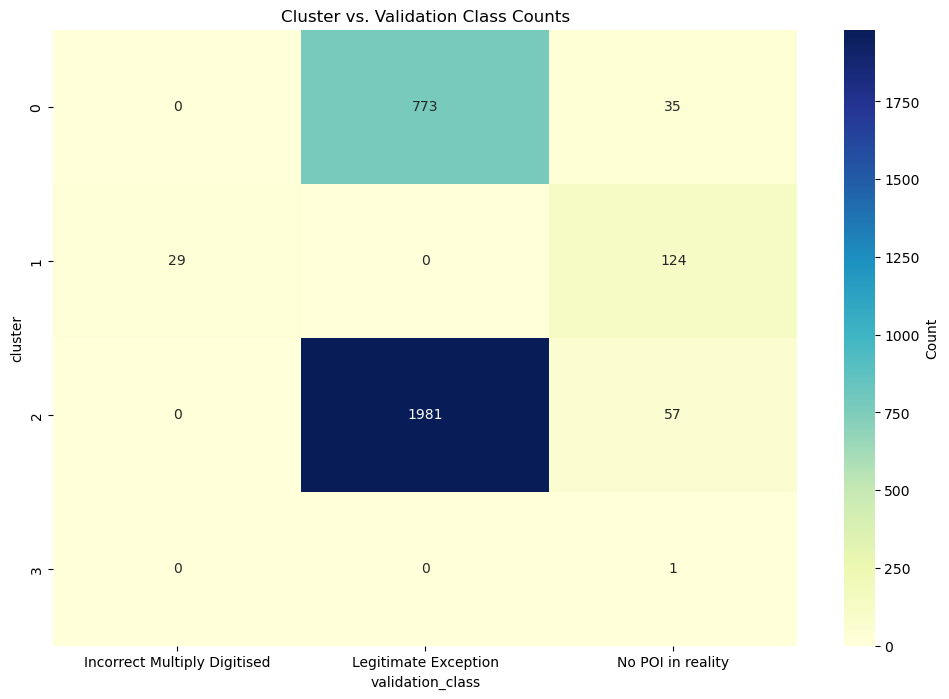

In [125]:

def main():
    # Configuración de rutas y parámetros
    POI_PATH = "/Users/albaruiz/Downloads/GuadalaHacks 2025/data 2/pois_with_voronoi_cells.geojson"
    STREET_PATH = "/Users/albaruiz/Downloads/GuadalaHacks 2025/data 2/pois_with_street_geometry.geojson"
    VORONOI_PATH = "/Users/albaruiz/Downloads/GuadalaHacks 2025/data 2/street_voronoi_polygons.geojson"
    
    OUTPUT_DIR = 'validation_results'
    SAMPLE_SIZE = 20
    NUM_CLUSTERS = 4

    try:
        # Crear directorio principal de resultados
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        
        # 1. Cargar datos geoespaciales
        pois, streets, voronoi = load_geospatial_data(POI_PATH, STREET_PATH, VORONOI_PATH)
        
        # 2. Extraer características
        feature_df = extract_poi_features(pois, voronoi, streets)
        
        # 3. Generar mapas de validación
        map_dir = os.path.join(OUTPUT_DIR, 'validation_maps')
        map_paths, building_status = generate_validation_maps(
            pois,       # POIs
            voronoi,    # Edificios (capa voronoi)
            streets,    # Calles
            voronoi,    # Capa voronoi (misma que edificios)
            map_dir,    # Directorio
            SAMPLE_SIZE)
        
        # 4. Clustering
        feature_df = cluster_pois(feature_df, NUM_CLUSTERS)
        
        # 5. Clasificación
        classified_df = classify_pois(feature_df)
        
        # 6. Mapa de validación completo
        validation_map_path = os.path.join(OUTPUT_DIR, 'full_validation_map.png')
        generate_map_with_validation(
            pois,       # POIs
            voronoi,    # Edificios
            streets,    # Calles
            voronoi,    # Voronoi
            classified_df,  # Clasificaciones
            validation_map_path)  # Ruta de salida
        
        # 7. Imágenes compuestas
        composite_dir = os.path.join(OUTPUT_DIR, 'composite_examples')
        sample_images = create_composite_images(
            pois,       # POIs
            voronoi,    # Edificios
            streets,    # Calles
            voronoi,    # Voronoi
            classified_df,  # Clasificaciones
            composite_dir)  # Directorio
        
        # 8. Matriz de confusión
        matrix_path = create_confusion_matrix(classified_df)
        
        # 9. Exportar resultados
        export_dir = os.path.join(OUTPUT_DIR, 'exports')
        csv_path, geojson_path = export_validation_results(pois, classified_df, export_dir)
        
        # 10. Evaluación detallada
        eval_dir = os.path.join(OUTPUT_DIR, 'evaluation')
        os.makedirs(eval_dir, exist_ok=True)
        
        classification_report, cm_path = evaluate_validation_results(classified_df, eval_dir)
        
        # 11. Reporte final actualizado
        report_path = os.path.join(OUTPUT_DIR, 'validation_report.md')
        with open(report_path, 'w') as f:
            f.write("\n".join(generate_validation_report(classified_df, sample_images, classification_report)))
        
        print(f"\n¡Proceso completado con éxito!")
        print(f"Resultados guardados en: {os.path.abspath(OUTPUT_DIR)}")
        print(matrix_path)

    except Exception as e:
        print(f"\nError en el proceso: {str(e)}")
        raise

if __name__ == "__main__":
    main()